In [8]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Check device configurations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create MNIST and CIFAR transform objects
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define hyper-parameters
batch_size = 4
mnist_input_size = 1
mnist_dimensions = 28
cifar_input_size = 3
cifar_dimensions = 32
num_classes = 10
num_epochs = 20
learning_rate = 0.01

# Establish the MNIST data set and loaders
mnist_trainset = torchvision.datasets.MNIST(root='./mnist_data',
                                            transform=mnist_transform,
                                            train=True,
                                            download=True)
mnist_testset = torchvision.datasets.MNIST(root='./mnist_data',
                                           transform=mnist_transform,
                                           train=False,
                                           download=True)
mnist_trainloader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2)
mnist_testloader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=2)

# Establish the CIFAR datasets and loaders
cifar_trainset = torchvision.datasets.CIFAR10(root='./cifar_data',
                                              transform=cifar_transform,
                                              train=True,
                                              download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./cifar_data',
                                             transform=cifar_transform,
                                             train=False,
                                             download=True)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=2)

# Convoluted neural networks (featuring a bonus network with dropout layers)
class NeuralNet1(nn.Module):
    def __init__(self, input_size, num_classes, dimensions):
        super(NeuralNet1, self).__init__()
        self.conv = nn.Conv2d(input_size, 16, 5, padding='same')
        self.fulc = nn.Linear(16*dimensions**2, num_classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.relu(self.conv(x))
        out = torch.flatten(out, 1)
        out = self.fulc(out)
        return out
class NeuralNet2(nn.Module):
    def __init__(self, input_size, num_classes, dimensions):
        super(NeuralNet2, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 6, 5, padding='same')
        self.conv2 = nn.Conv2d(6, 16, 5, padding='same')
        self.fulc1 = nn.Linear(16*dimensions**2, 84)
        self.fulc2 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = torch.flatten(out, 1)
        out = self.relu(self.fulc1(out))
        out = self.fulc2(out)
        return out
class NeuralNet3(nn.Module):
    def __init__(self, input_size, num_classes, dimensions):
        super(NeuralNet3, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 6, 5, padding='same')
        self.norm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5, padding='same')
        self.norm2 = nn.BatchNorm2d(16)
        self.fulc1 = nn.Linear(16*(dimensions//4)**2, 120)
        self.fulc2 = nn.Linear(120, 84)
        self.fulc3 = nn.Linear(84, num_classes)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.pool(self.relu(self.norm1(self.conv1(x))))
        out = self.pool(self.relu(self.norm2(self.conv2(out))))
        out = torch.flatten(out, 1)
        out = self.relu(self.fulc1(out))
        out = self.relu(self.fulc2(out))
        out = self.fulc3(out)
        return out
class NeuralNet4(nn.Module):
    def __init__(self, input_size, num_classes, dimensions):
        super(NeuralNet4, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 16, 3, padding='same')
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.norm2 = nn.BatchNorm2d(32)
        self.fulc1 = nn.Linear(32*(dimensions//4)**2, 128)
        self.norm3 = nn.BatchNorm2d(128)
        self.fulc2 = nn.Linear(128, 64)
        self.norm4 = nn.BatchNorm2d(64)
        self.fulc3 = nn.Linear(64, num_classes)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.edrop = nn.Dropout(p=0.2)
        self.cdrop = nn.Dropout2d(p=0.1)
    def forward(self, x):
        out = self.pool(self.relu(self.edrop(self.norm1(self.conv1(x)))))
        out = self.pool(self.relu(self.edrop(self.norm2(self.conv2(out)))))
        out = torch.flatten(self.cdrop(out), 1)
        out = self.relu(self.edrop(self.fulc1(out)))
        out = self.relu(self.edrop(self.fulc2(out)))
        out = self.fulc3(out)
        return out

# Create network models
mnistnet1 = NeuralNet1(mnist_input_size,num_classes,mnist_dimensions).to(device)
mnistnet2 = NeuralNet2(mnist_input_size,num_classes,mnist_dimensions).to(device)
mnistnet3 = NeuralNet3(mnist_input_size,num_classes,mnist_dimensions).to(device)
mnistnet4 = NeuralNet4(mnist_input_size,num_classes,mnist_dimensions).to(device)
mnistnets = [mnistnet1, mnistnet2, mnistnet3, mnistnet4]
cifarnet1 = NeuralNet1(cifar_input_size,num_classes,cifar_dimensions).to(device)
cifarnet2 = NeuralNet2(cifar_input_size,num_classes,cifar_dimensions).to(device)
cifarnet3 = NeuralNet3(cifar_input_size,num_classes,cifar_dimensions).to(device)
cifarnet4 = NeuralNet4(cifar_input_size,num_classes,cifar_dimensions).to(device)
cifarnets = [cifarnet1, cifarnet2, cifarnet3, cifarnet4]

# Train and test each MNIST net first
print('Initiating MNIST Training for', len(mnistnets), 'networks')
for mnistnet in mnistnets:
    # Initiate timer, TensorBoard writer, loss criterion, and optimizer
    time_start = time.time()
    writer = SummaryWriter()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mnistnet.parameters(), lr=learning_rate)

    # Train model by looping over the dataset per epoch per data
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(mnist_trainloader, 0):
            # Extract data tuple to device in inputs and labels, respectively
            inputs, labels = data[0].to(device), data[1].to(device)
            # Zero out parameter gradients
            optimizer.zero_grad()
            # Forward pass then backpropagate and optimize
            outputs = mnistnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Print and write progress for every databatch of 2500
            running_loss += loss.item()
            if i % 2500 == 2499:
                print(f'[{epoch + 1}/{num_epochs}, {i + 1:5d}/{len(mnist_trainloader)}] loss: {running_loss / 2500:.3f}')
                writer.add_scalar("Loss/train", running_loss, epoch * len(mnist_trainloader) + i)
                running_loss = 0.0
    # Calculate time it took to train
    time_total = (time.time() - time_start)
    print('Finished MNIST Training', str(mnistnets.index(mnistnet)+1) + '/' + str(len(mnistnets)), 'in', str(int(time_total//60)) + 'm' + str(int(time_total%60)) + 's')

    # Model testing (gradients are need not computed for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in mnist_testloader:
            # Parse data to device, whether NVIDIA CUDA or CPU
            images = images.to(device)
            labels = labels.to(device)
            # Run the images through the network to get our outputs
            outputs = mnistnet(images)
            # Predict the class with the highest energy
            _, predicted = torch.max(outputs.data, 1)
            # Adjust prediction counters and print the given accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the', len(mnist_testloader), 'test images: {} %'.format(100 * correct / total))
    print('Finished MNIST Testing', str(mnistnets.index(mnistnet)+1) + '/' + str(len(mnistnets)) + '\n')

    # Flush and close TensorBoard writer then save the model checkpoint
    writer.flush()
    writer.close()
    torch.save(mnistnet.state_dict(), 'mnistnet' + str(mnistnets.index(mnistnet)+1) + '.ckpt')

# Repeat train and test with CIFAR nets (retains same comments for clarity)
print('\n\nInitiating CIFAR Training for', len(cifarnets), 'networks')
for cifarnet in cifarnets:
    # Initiate timer, TensorBoard writer, loss criterion, and optimizer
    time_start = time.time()
    writer = SummaryWriter()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cifarnet.parameters(), lr=learning_rate)

    # Train model by looping over the dataset per epoch per data
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(cifar_trainloader, 0):
            # Extract data tuple to device in inputs and labels, respectively
            inputs, labels = data[0].to(device), data[1].to(device)
            # Zero out parameter gradients
            optimizer.zero_grad()
            # Forward pass then backpropagate and optimize
            outputs = cifarnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Print progress for every databatch of 2500
            running_loss += loss.item()
            if i % 2500 == 2499:
                print(f'[{epoch + 1}/{num_epochs}, {i + 1:5d}/{len(cifar_trainloader)}] loss: {running_loss / 2500:.3f}')
                writer.add_scalar("Loss/train", running_loss, epoch * len(cifar_trainloader) + i)
                running_loss = 0.0
    # Calculate time it took to train
    time_total = (time.time() - time_start)
    print('Finished CIFAR Training', str(cifarnets.index(cifarnet)+1) + '/' + str(len(cifarnets)), 'in', str(int(time_total//60)) + 'm' + str(int(time_total%60)) + 's')

    # Model testing (gradients are not computed for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in cifar_testloader:
            # Parse data to our device, whether NVIDIA CUDA or the CPU
            images = images.to(device)
            labels = labels.to(device)
            # Run the images through the network to get our outputs
            outputs = cifarnet(images)
            # Predict the class with the highest energy
            _, predicted = torch.max(outputs.data, 1)
            # Adjust prediction counters and print the given accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the', len(cifar_testloader), 'test images: {} %'.format(100 * correct / total))
    print('Finished CIFAR Testing', str(cifarnets.index(cifarnet)+1) + '/' + str(len(cifarnets)) + '\n')

    # Flush and close TensorBoard writer then save the model checkpoint
    writer.flush()
    writer.close()
    torch.save(cifarnet.state_dict(), 'cifarnet' + str(cifarnets.index(cifarnet)+1) + '.ckpt')

Files already downloaded and verified
Files already downloaded and verified
Initiating MNIST Training for 4 networks


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1/20,  2500/15000] loss: 0.331
[1/20,  5000/15000] loss: 0.157
[1/20,  7500/15000] loss: 0.122
[1/20, 10000/15000] loss: 0.108
[1/20, 12500/15000] loss: 0.099
[1/20, 15000/15000] loss: 0.086
[2/20,  2500/15000] loss: 0.070
[2/20,  5000/15000] loss: 0.065
[2/20,  7500/15000] loss: 0.062
[2/20, 10000/15000] loss: 0.061
[2/20, 12500/15000] loss: 0.073
[2/20, 15000/15000] loss: 0.065
[3/20,  2500/15000] loss: 0.042
[3/20,  5000/15000] loss: 0.050
[3/20,  7500/15000] loss: 0.050
[3/20, 10000/15000] loss: 0.046
[3/20, 12500/15000] loss: 0.045
[3/20, 15000/15000] loss: 0.053
[4/20,  2500/15000] loss: 0.031
[4/20,  5000/15000] loss: 0.031
[4/20,  7500/15000] loss: 0.040
[4/20, 10000/15000] loss: 0.045
[4/20, 12500/15000] loss: 0.045
[4/20, 15000/15000] loss: 0.036
[5/20,  2500/15000] loss: 0.026
[5/20,  5000/15000] loss: 0.028
[5/20,  7500/15000] loss: 0.027
[5/20, 10000/15000] loss: 0.027
[5/20, 12500/15000] loss: 0.033
[5/20, 15000/15000] loss: 0.036
[6/20,  2500/15000] loss: 0.024
[6/20,  

Of the models that had the least amount of error for validation, the MNIST models were far more accurate than the CIFAR models were. The MNIST models were highly precise, with a range of 0.65. They also had near-perfect accuracy, with the worst case being 98.53%, and the best case being 99.18%. Conversely, the CIFAR models were less optimal, with a wider accuracy range of 16.71. Additionaly, their accuracy, while better than pure chance, was only 68.95% accurate at best and 52.24% at worst. This is most likely due to the fact that not only the CIFAR set is much tougher to train with, but also contains smaller datasets. This makes it very subject to overfitting. To counteract this, I made a fourth neural network that added dropout layers into the model. The layers help vary the training data by zeroing out random elements and sometimes even entire channels. This was beneficial, as the fourth neural network was the most accurate of the four in the CIFAR dataset, despite having the worst training accuracy. It was also very acurrate in the MNIST dataset, being only 0.02% behind the best network, which was the second one. It should be noted that th accuracy for the CIFAR datasets did increase with each successive model. This is especially the case with the last twp neural networks, as they used batch normalization, and the last one using the afformentioned dropout layers. It should be noted that the CIFAR models had computed faster than the MNIST models, most likely due to the smaller datasets. Both datasets took more time with each successive neural network, however.

MNIST TIME AND ACCURACY
*   Net 1 - 18m10s (98.53%)
*   Net 2 - 21m13s (99.18%)
*   Net 3 - 25m31s (99.06%)
*   Net 4 - 27m07s (99.16%)
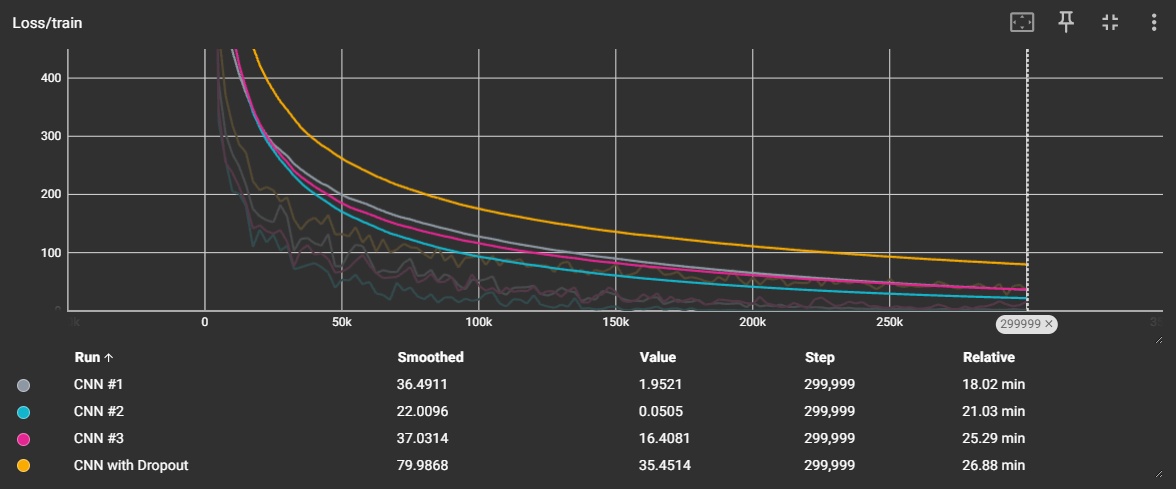

CIFAR TIME AND ACCURACY
*   Net 1 - 15m23s (52.24%)
*   Net 2 - 17m45s (54.26%)
*   Net 3 - 21m23s (64.06%)
*   Net 4 - 23m10s (68.95%)
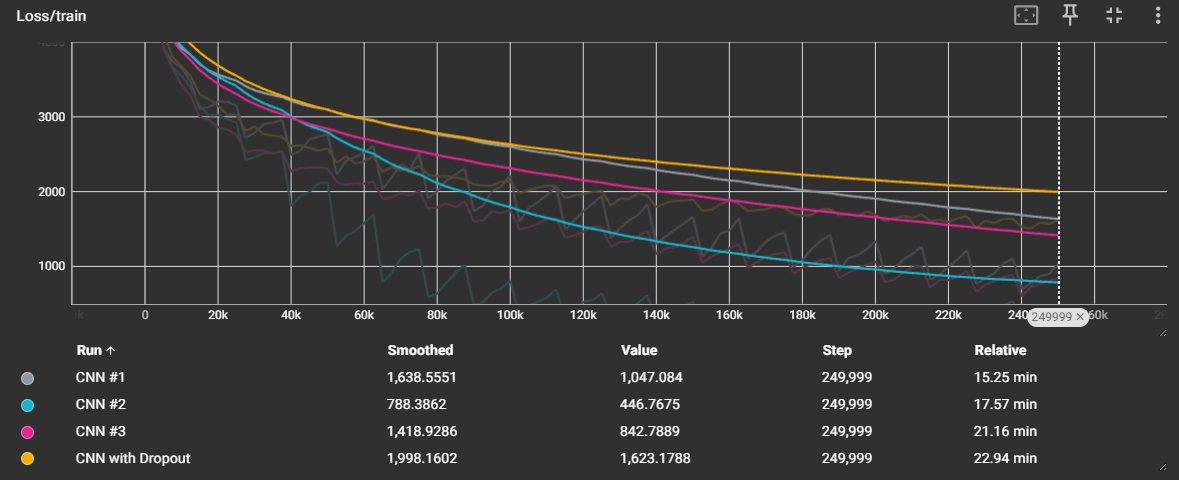